In [3]:
%load_ext autoreload 
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Weather radar image
This notebook does the same as exercise 6, but the data are sampled randomly from the weather radar image instead of a low res blurred version. Repeating this process and then averaging would be similar to Bootstrap resampling, only that we in this case have too much data whereas in bootstrap we have too little. I did not have the time to finish this little project, but I still include it in the repo as an interesting idea:) 

In [1]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
radar = np.load("nedbor_radar.npy") # from 2021-10-06 kl 11:45

### Plot grayscale rain

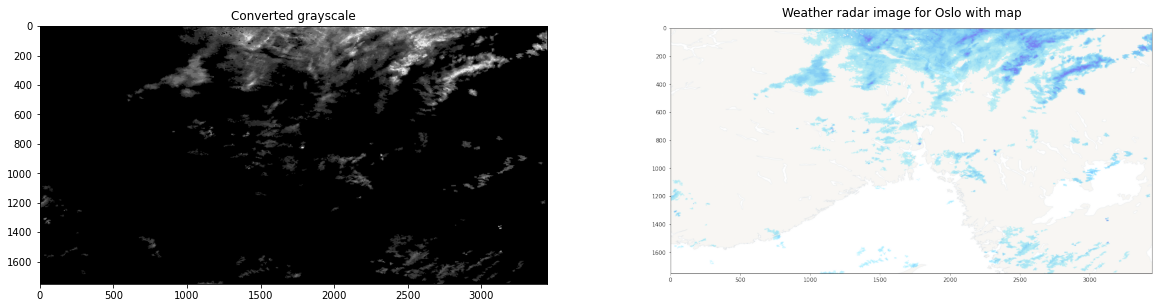

In [3]:
import matplotlib.image as mpimg
fig, ax = plt.subplots(1, 2, figsize=(20,15))
ax[0].imshow(radar, cmap='gray')
ax[0].set_title('Converted grayscale')
bilde_norge = mpimg.imread('./bilde_norge.png')
ax[1].imshow(bilde_norge, cmap='gray')
ax[1].set_title('Weather radar image for Oslo with map')
plt.axis('off')
plt.show()

### Reduce resolution of image

# OLS, Lasso and Ridge on weather radar image
In the following I do a polynomial fit to the weather radar image using OLS, Lasso and Ridge regression. The lambda for lasso is set as low as possible without computational time increasing unreasonably much. 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tqdm # progressbar

# my own library
from regression import OLS
from regression import Ridge

#sk-learn linear regression for lasso analysis
from sklearn.linear_model import Lasso as Lasso_skl
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

#z = radar_rescaled
#x = np.arange(z.shape[1])
#y = np.arange(z.shape[0])
#x, y = np.meshgrid(x, y)

# Random sampeling from image:
x = np.arange(radar.shape[1])
y = np.arange(radar.shape[0])
x, y = np.meshgrid(x, y)
x_ = x.ravel()
y_ = y.ravel()
radar_ = radar.ravel()

n = 50*50*10 #50x50 array has been computationally OK befor, times 10 just because... 
points = np.random.randint(0, x.size, n)
x_ = x_[points]
y_ = y_[points]
z_ = radar_[points]

poly = 30
k_folds = 7

MSE_test_OLS = [] 
MSE_train_OLS = []
betas_OLS = []

MSE_test_Ridge = [] 
MSE_train_Ridge = []
betas_Ridge = []
MSE_test_Ridge_l = [] 
MSE_train_Ridge_l = []
betas_Ridge_l = []

MSE_test_Lasso = [] 
MSE_train_Lasso = []
betas_Lasso = []
MSE_test_Lasso_l = [] 
MSE_train_Lasso_l = []
betas_Lasso_l = []

#Scale data
x_cent =  ((x_ - np.mean(x_))/np.mean(x_)).reshape(-1, 1)   
y_cent =  ((y_ - np.mean(y_))/np.mean(y_)).reshape(-1, 1) 
z_cent =  ((z_ - np.mean(z_))/np.mean(z_)).reshape(-1, 1) 

# Cross validation:
# shuffle data:
order = np.arange(x_cent.shape[0]) # number of z-values
np.random.shuffle(order)
x_cent_ = x_cent[order].ravel().reshape(-1,1)
y_cent_ = y_cent[order].ravel().reshape(-1,1)
z_cent_ = z_cent[order].ravel().reshape(-1,1)
xyz_shuffle = np.hstack([x_cent_, y_cent_, z_cent_])
xyz_folds = np.array_split(xyz_shuffle, k_folds) # split into k-folds

for k in tqdm.tqdm(range(k_folds)):     
    # extract folds
    xyz_test = xyz_folds[k] # k-th fold is test 
    xyz_train = np.vstack([xyz_folds[f] for f in range(k_folds) if f != k]) # skip k-th fold

    xy_train = xyz_train[:, 0:2]
    z_train = xyz_train[:, 2].reshape(-1, 1)
    xy_test = xyz_test[:, 0:2]
    z_test = xyz_test[:, 2].reshape(-1, 1)    
    
    # OLS:
    MSE_test = []
    MSE_train = []
    beta_poly = np.zeros([poly, int((poly + 1)*(poly + 2)/2)])
    for poly_deg in range(1, poly + 1):
        model = OLS(xy_train[:, 0].ravel(), xy_train[:, 1].ravel(), z_train.ravel(), poly_deg)
        MSE_test.append(model.MSE(xy_test[:, 0], xy_test[:, 1], z_test.ravel())) 
        MSE_train.append(model.MSE(xy_train[:, 0], xy_train[:, 1], z_train.ravel()))
        beta_poly[poly_deg-1, 0: int((poly_deg + 1)*(poly_deg + 2)/2)] = np.array(model.beta_OLS.ravel()) 
        beta_poly[poly_deg-1, int((poly_deg + 1)*(poly_deg + 2)/2):] = np.nan
        
    MSE_test_OLS.append(MSE_test) 
    MSE_train_OLS.append(MSE_train)
    betas_OLS.append(beta_poly) 


    # Ridge:
    MSE_test = []
    MSE_train = []
    beta_poly = np.zeros([poly, int((poly + 1)*(poly + 2)/2)])
    lambda_ridge = 50
    for poly_deg in range(1, poly + 1):
        model = Ridge(xy_train[:, 0].ravel(), xy_train[:, 1].ravel(), z_train.ravel(), poly_deg, lambda_ridge) 
        MSE_test.append(model.MSE(xy_test[:, 0], xy_test[:, 1], z_test.ravel())) 
        MSE_train.append(model.MSE(xy_train[:, 0], xy_train[:, 1], z_train.ravel()))
        beta_poly[poly_deg-1, 0: int((poly_deg + 1)*(poly_deg + 2)/2)] = np.array(model.beta_Ridge.ravel()) 
        beta_poly[poly_deg-1, int((poly_deg + 1)*(poly_deg + 2)/2):] = np.nan
        
    MSE_test_Ridge.append(MSE_test) 
    MSE_train_Ridge.append(MSE_train)
    betas_Ridge.append(beta_poly) 
  
    # Ridge, lower lambda:
    MSE_test = []
    MSE_train = []
    beta_poly = np.zeros([poly, int((poly + 1)*(poly + 2)/2)])
    lambda_ridge_l = 0.0001
    for poly_deg in range(1, poly + 1):
        model = Ridge(xy_train[:, 0].ravel(), xy_train[:, 1].ravel(), z_train.ravel(), poly_deg, lambda_ridge_l) 
        MSE_test.append(model.MSE(xy_test[:, 0], xy_test[:, 1], z_test.ravel())) 
        MSE_train.append(model.MSE(xy_train[:, 0], xy_train[:, 1], z_train.ravel()))
        beta_poly[poly_deg-1, 0: int((poly_deg + 1)*(poly_deg + 2)/2)] = np.array(model.beta_Ridge.ravel()) 
        beta_poly[poly_deg-1, int((poly_deg + 1)*(poly_deg + 2)/2):] = np.nan
        
    MSE_test_Ridge_l.append(MSE_test) 
    MSE_train_Ridge_l.append(MSE_train)
    betas_Ridge_l.append(beta_poly) 
    
    # Lasso:
    MSE_test = []
    MSE_train = []
    beta_poly = np.zeros([poly, int((poly + 1)*(poly + 2)/2)])
    lambda_lasso = 0.05
    iterations = 10000
    for poly_deg in range(1, poly + 1):
        model_skl = make_pipeline(PolynomialFeatures(degree=poly_deg), Lasso_skl(
            alpha=lambda_lasso, fit_intercept=False, max_iter=iterations)).fit(xy_train, z_train.reshape(-1, 1))
        beta_poly[poly_deg-1, 0: int((poly_deg + 1)*(poly_deg + 2)/2)] = model_skl.steps[1][1].coef_
        beta_poly[poly_deg-1, int((poly_deg + 1)*(poly_deg + 2)/2):] = np.nan  
        MSE_test.append(np.mean((model_skl.predict(xy_test).ravel() - z_test.ravel())**2)) 
        MSE_train.append(np.mean((model_skl.predict(xy_train).ravel() - z_train.ravel())**2)) 

    MSE_test_Lasso.append(MSE_test) 
    MSE_train_Lasso.append(MSE_train)
    betas_Lasso.append(beta_poly) 
    
    # Lasso, lower lambda: 0.025 original for plotted
    MSE_test = []
    MSE_train = []
    beta_poly = np.zeros([poly, int((poly + 1)*(poly + 2)/2)])
    lambda_lasso_l = 0.001
    iterations = 10000
    for poly_deg in range(1, poly + 1):
        model_skl = make_pipeline(PolynomialFeatures(degree=poly_deg), Lasso_skl(
            alpha=lambda_lasso_l, fit_intercept=False, max_iter=iterations)).fit(xy_train, z_train.reshape(-1, 1))
        beta_poly[poly_deg-1, 0: int((poly_deg + 1)*(poly_deg + 2)/2)] = model_skl.steps[1][1].coef_
        beta_poly[poly_deg-1, int((poly_deg + 1)*(poly_deg + 2)/2):] = np.nan  
        MSE_test.append(np.mean((model_skl.predict(xy_test).ravel() - z_test.ravel())**2)) 
        MSE_train.append(np.mean((model_skl.predict(xy_train).ravel() - z_train.ravel())**2)) 

    MSE_test_Lasso_l.append(MSE_test) 
    MSE_train_Lasso_l.append(MSE_train)
    betas_Lasso_l.append(beta_poly) 
    
#convert to array
MSE_test_OLS = np.array(MSE_test_OLS)
MSE_train_OLS = np.array(MSE_train_OLS)
betas_OLS = np.array(betas_OLS)

MSE_test_Ridge = np.array(MSE_test_Ridge)
MSE_train_Ridge = np.array(MSE_train_Ridge)
betas_Ridge = np.array(betas_Ridge)
MSE_test_Ridge_l = np.array(MSE_test_Ridge_l)
MSE_train_Ridge_l = np.array(MSE_train_Ridge_l)
betas_Ridge_l = np.array(betas_Ridge_l)

MSE_test_Lasso = np.array(MSE_test_Lasso)
MSE_train_Lasso = np.array(MSE_train_Lasso)
betas_Lasso = np.array(betas_Lasso)
MSE_test_Lasso_l = np.array(MSE_test_Lasso_l)
MSE_train_Lasso_l = np.array(MSE_train_Lasso_l)
betas_Lasso_l = np.array(betas_Lasso_l)

#study average values
expected_MSE_test_OLS = np.mean(MSE_test_OLS, axis=0) 
expected_MSE_train_OLS  = np.mean(MSE_train_OLS, axis=0)
mean_betas_OLS = np.mean(betas_OLS, axis=0)

expected_MSE_test_Ridge = np.mean(MSE_test_Ridge, axis=0) 
expected_MSE_train_Ridge  = np.mean(MSE_train_Ridge, axis=0)
mean_betas_Ridge = np.mean(betas_Ridge, axis=0)
expected_MSE_test_Ridge_l = np.mean(MSE_test_Ridge_l, axis=0) 
expected_MSE_train_Ridge_l  = np.mean(MSE_train_Ridge_l, axis=0)
mean_betas_Ridge_l = np.mean(betas_Ridge_l, axis=0)

expected_MSE_test_Lasso = np.mean(MSE_test_Lasso, axis=0) 
expected_MSE_train_Lasso  = np.mean(MSE_train_Lasso, axis=0)
mean_betas_Lasso = np.mean(betas_Lasso, axis=0)
expected_MSE_test_Lasso_l = np.mean(MSE_test_Lasso_l, axis=0) 
expected_MSE_train_Lasso_l  = np.mean(MSE_train_Lasso_l, axis=0)
mean_betas_Lasso_l = np.mean(betas_Lasso_l, axis=0)

 29%|████████████▌                               | 2/7 [05:58<15:04, 180.96s/it]

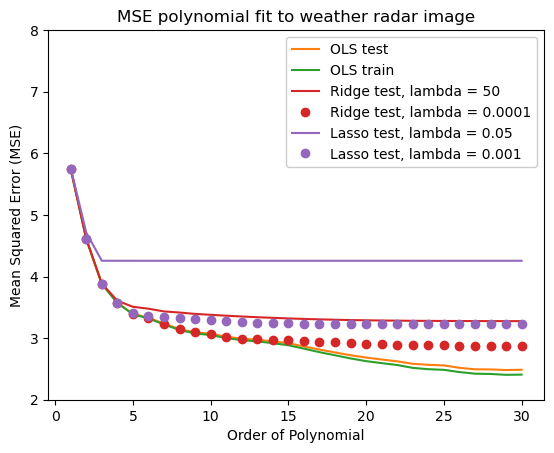

In [10]:
import matplotlib.pyplot as plt
plt.style.use('default')
plt.plot(range(1, len(MSE_test)+1), expected_MSE_test_OLS, 'C1', label='OLS test')
plt.plot(range(1, len(MSE_train)+1), expected_MSE_train_OLS, 'C2', label='OLS train')
plt.plot(range(1, len(MSE_test)+1), expected_MSE_test_Ridge, 'C3', 
         label='Ridge test, lambda = ' + str(lambda_ridge))
plt.plot(range(1, len(MSE_test)+1), expected_MSE_test_Ridge_l, 'C3o', 
         label='Ridge test, lambda = ' + str(lambda_ridge_l))
plt.plot(range(1, len(MSE_test)+1), expected_MSE_test_Lasso, 'C4', 
         label='Lasso test, lambda = ' + str(lambda_lasso))
plt.plot(range(1, len(MSE_test)+1), expected_MSE_test_Lasso_l, 'C4o', 
         label='Lasso test, lambda = ' + str(lambda_lasso_l))
plt.legend(loc='upper right', framealpha=1)
plt.xlabel('Order of Polynomial')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE polynomial fit to weather radar image')
plt.ylim(2, 8)
plt.show()

# Plot expected beta for different polynomials with Lasso, Ridge and OLS

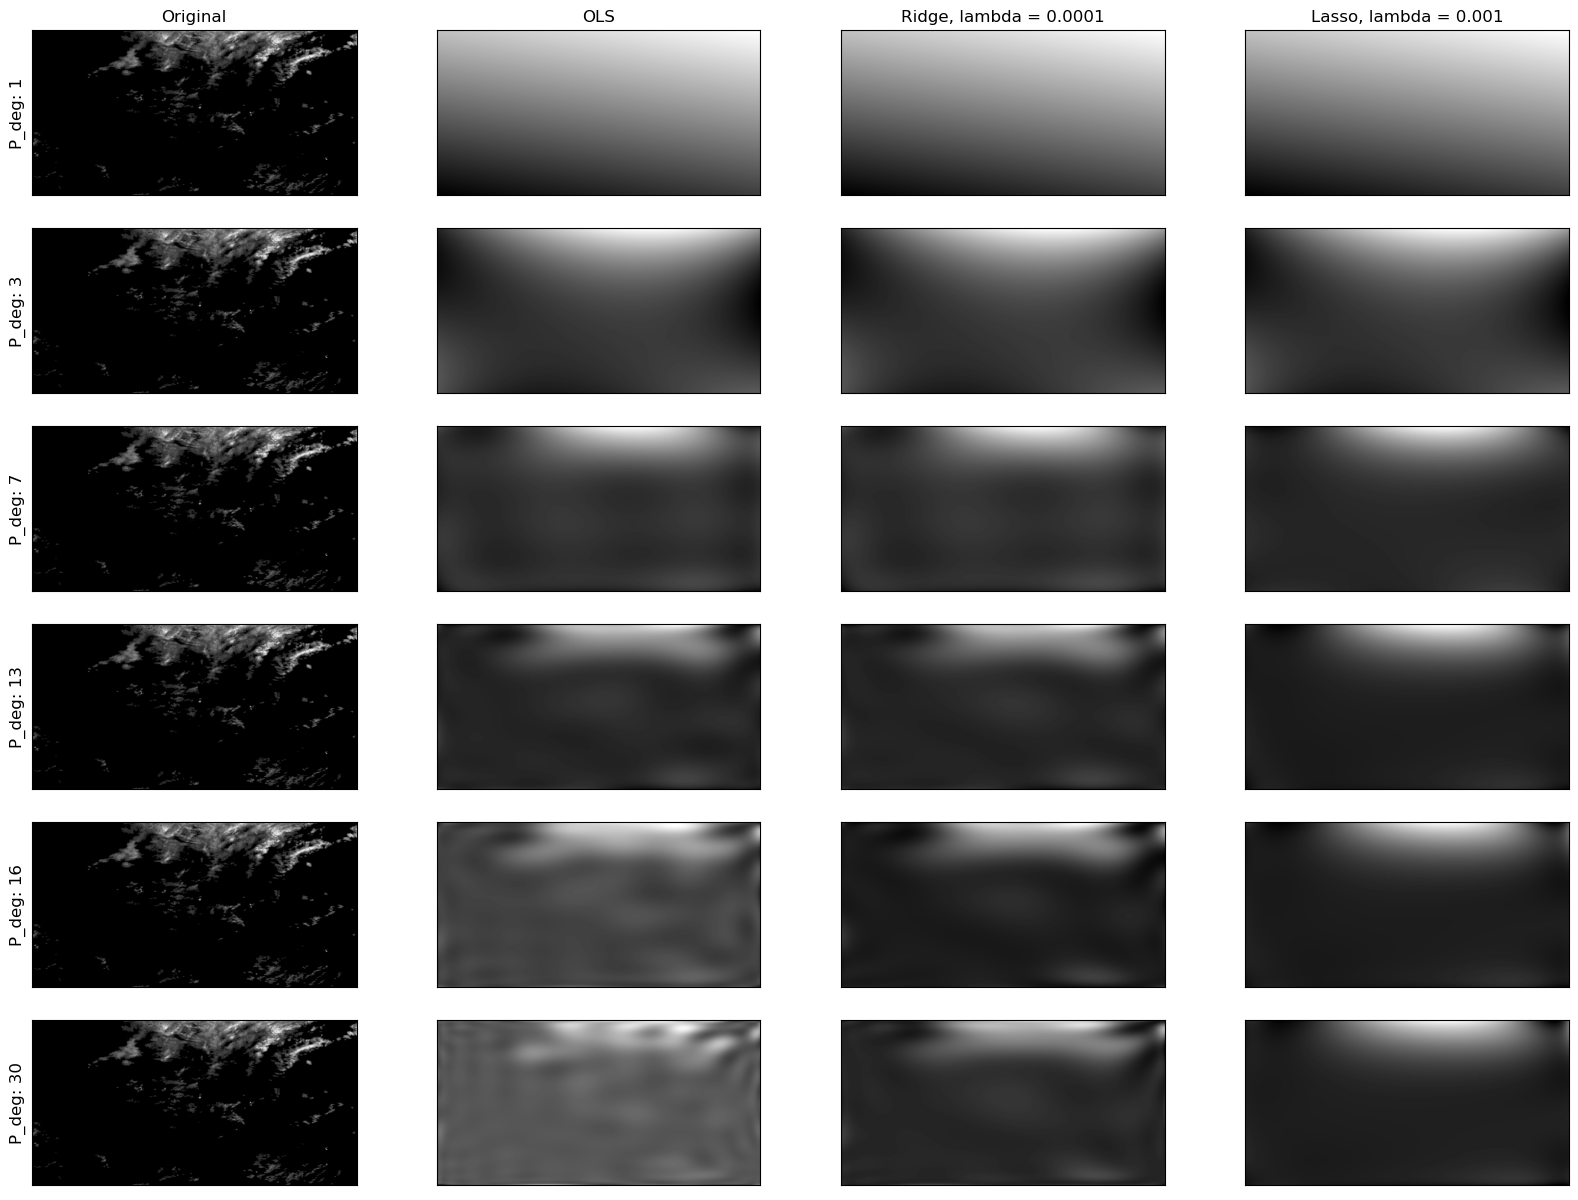

In [11]:
# Recreate terrain
import matplotlib.pyplot as plt
import numpy as np

interesting_degrees = [0, 2, 6, 12, 15, 29]

fig, axs = plt.subplots(len(interesting_degrees), 4, figsize=(20, 15), facecolor='w', edgecolor='k') 
c_plot = 0
for p_number in interesting_degrees: 
    optimal_beta_OLS = mean_betas_OLS[p_number][~np.isnan(mean_betas_OLS[p_number])]
    optimal_beta_Ridge = mean_betas_Ridge_l[p_number][~np.isnan(mean_betas_Ridge[p_number])]
    optimal_beta_Lasso = mean_betas_Lasso_l[p_number][~np.isnan(mean_betas_Lasso[p_number])]

    p_OLS = int((-1 + np.sqrt(1 + 4*2*len(optimal_beta_OLS)))/2) - 1 # pOLS = p_number
    # Fit a new polynomial using optimal beta: 
    x_ = ((x - np.mean(x))/np.mean(x))[::10, ::10].ravel()
    y_ = ((y - np.mean(y))/np.mean(y))[::10, ::10].ravel()
    
    M = np.zeros([len(x_.ravel()), int((p_OLS+1)*(p_OLS+2)/2)])
    c = 0

    for j in range(0, p_OLS+1): # y**j
        for i in range(0, p_OLS+1 -j): # x **i
            M[:, c] = (x_**i)*(y_**j)
            c += 1

    #Polynomial features stacks design matrix in a different order:
    M_Lasso = np.zeros([len(x_.ravel()), int((p_OLS+1)*(p_OLS+2)/2)])
    c = 0
    for i in range(0, p_OLS+1): # x**i
        for j in range(0, i+1): # y **i
            M_Lasso[:, c] = (x_**(i - j))*(y_**j) # traverse diagonal
            c += 1
            
    z_pred_OLS = (M @ optimal_beta_OLS).reshape(radar[::10, ::10].shape)
    z_pred_Ridge = (M @ optimal_beta_Ridge).reshape(radar[::10, ::10].shape)
    z_pred_Lasso = (M_Lasso @ optimal_beta_Lasso).reshape(radar[::10, ::10].shape)

    #Plot:
    axs[c_plot, 1].imshow(z_pred_OLS, cmap='gray')
    axs[c_plot, 2].imshow(z_pred_Ridge, cmap='gray')
    axs[c_plot, 3].imshow(z_pred_Lasso, cmap='gray')
    axs[c_plot, 0].imshow(radar, cmap='gray')

    #Style: 
    for i in range(4):
        axs[c_plot, i].xaxis.set_ticklabels([])
        axs[c_plot, i].yaxis.set_ticklabels([])
        axs[c_plot, i].set_xticks([])
        axs[c_plot, i].set_yticks([])
    axs[c_plot, 0].set_ylabel('P_deg: ' + str(p_number + 1), fontsize=12)
    
    c_plot = c_plot + 1

axs[0, 0].set_title('Original')
axs[0, 1].set_title('OLS')
axs[0, 2].set_title('Ridge, lambda = ' + str(lambda_ridge_l))
axs[0, 3].set_title('Lasso, lambda = ' + str(lambda_lasso_l))
plt.show()

# pictures must be reconstructed using original 

In [1]:
# Ridge seems a bit more precise tho? 